In [12]:
import urllib3

#fetch GFS data and plot at ENA
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import netCDF4
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from datetime import datetime, timedelta
from netCDF4 import num2date, Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import tempfile

%matplotlib inline


In [55]:
def tplot(ncss, bbox, delta=0, tk=.5, vmin = None, vmax = None):
    north = bbox[3]
    south = bbox[2]
    west = bbox[1]
    east = bbox[0]
    query = ncss.query()
    query.lonlat_box(north=north, south=south, 
                     east=east, west=west).time(datetime.utcnow() + timedelta(hours=delta))
    query.accept('netcdf4')
    query.variables('Planetary_Boundary_Layer_Height_surface', 'Temperature_surface',
                    'MSLP_Eta_model_reduction_msl')
    data = ncss.get_data(query)
    print(list(data.variables))
    pbl_var = data.variables['Planetary_Boundary_Layer_Height_surface']
    mslp_var = data.variables['MSLP_Eta_model_reduction_msl']
    temp_var = data.variables['Temperature_surface']
    
    # Time variables can be renamed in GRIB collections. Best to just pull it out of the
    # coordinates attribute on temperature
    time_name = temp_var.coordinates.split()[1]
    time_var = data.variables[time_name]
    lat_var = data.variables['lat']
    lon_var = data.variables['lon']

    pbl_vals = pbl_var[:].squeeze()
    lat_vals = lat_var[:].squeeze()
    lon_vals = lon_var[:].squeeze()
    mslp_vals = mslp_var[:].squeeze() / 100.0 
    temp_vals = temp_var[:].squeeze() - 273.15

    # Convert the number of hours since the reference time to an actual date
    time_val = num2date(time_var[:].squeeze(), time_var.units)


    # Combine 1D latitude and longitudes into a 2D grid of locations
    lon_2d, lat_2d = np.meshgrid(lon_vals, lat_vals)

    # Create a new figure
    fig = plt.figure(figsize=(15, 12))

    # Add the map and set the extent
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_xticks(np.arange(west, east, tk), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(south, north, tk), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    ax.set_extent(bbox)

    # Add state boundaries to plot
    coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                                facecolor='none', name='coastline')
    _ = ax.add_feature(coast, edgecolor='black')


    # Contour temperature at each lat/long
    cf = ax.pcolormesh(lon_2d, lat_2d, temp_vals, transform=ccrs.PlateCarree(), zorder=0,
                     cmap='coolwarm', vmin=vmin, vmax=vmax)

    cn = ax.contour(lon_2d, lat_2d, mslp_vals, np.arange(1000, 1040, 2), colors='black')

    plt.clabel(cn, inline=1, fontsize=15, fmt='%1.0f')


    # Plot a colorbar to show temperature and reduce the size of it
    plt.colorbar(cf, ax=ax, fraction=0.032)

    # Make a title with the time value
    ax.set_title(u'Temperature forecast (\u00b0C) for {0:%d %B %Y %H:%MZ}'.format(time_val),
                 fontsize=20)


    ax.plot([ter_lon, gra_lon], [ter_lat, gra_lat],
           'ro', transform=ccrs.PlateCarree())

    ax.text(ter_lon+.2, ter_lat+.2, 
            'Tericia', transform=ccrs.PlateCarree(), fontsize = 16)

    ax.text(gra_lon+.2, gra_lat+.2, 
            'Graciosa', transform=ccrs.PlateCarree(), fontsize = 16)

In [62]:
url='https://www-pm.larc.nasa.gov/cgi-bin/site/showdoc?docid=22&c=binary-download&domain=amf_azores&type=P&year=2017&month=02&day=17&fn=MT10V03.0.AMFAZRS.2017048.1800.PX.03K.NC'
localfile = tempfile.NamedTemporaryFile()

In [63]:
connection_pool = urllib3.PoolManager()
resp = connection_pool.request('GET',url )
f = open(localfile.name, 'wb')
f.write(resp.data)
f.close()
resp.release_conn()

/Users/scollis/anaconda/envs/ams-workshop/lib/python3.5/site-packages/urllib3/connectionpool.py:730: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.org/en/latest/security.html (This warning will only appear once by default.)
  InsecureRequestWarning)


In [64]:
mydata = Dataset(localfile.name)

In [65]:
print(mydata.variables.keys())

odict_keys(['vis_063_calib', 'temp_nir_calib', 'temp_ir_calib', 'temp_wv_calib', 'temp_sw_calib', 'mc_directory_header', 'mc_navigation_header', 'mc_calibration_header', 'grid_lat', 'grid_lon', 'solar_zenith_angle', 'view_zenith_angle', 'azimuth_zenith_angle', 'clearsky_vis_reflectance', 'skin_temperature', 'clearsky_ir_temperature', 'visst_netcdf_version', 'base_time', 'time_offset', 'scanline_time', 'image_y', 'image_x', 'latitude', 'longitude', 'reflectance_vis', 'visible_count', 'reflectance_nir', 'temperature_sir', 'temperature_67', 'temperature_ir', 'temperature_sw', 'broadband_shortwave_albedo', 'broadband_longwave_flux', 'cloud_ir_emittance', 'cloud_phase', 'cloud_visible_optical_depth', 'cloud_particle_size', 'cloud_lwp_iwp', 'cloud_effective_temperature', 'cloud_top_pressure', 'cloud_effective_pressure', 'cloud_bottom_pressure', 'cloud_top_height', 'cloud_effective_height', 'cloud_bottom_height', 'cloud_top_temperature', 'cloud_bottom_temperature', 'pixel_skin_temperature', '

In [66]:
lat_2d = mydata.variables['latitude'][:]
lon_2d = mydata.variables['longitude'][:]

temp_vals = mydata.variables['temperature_ir'][:] -273.15


In [67]:
print(temp_vals.min())

-40.73


In [68]:
time_val = num2date(mydata.variables['time_offset'][:], mydata.variables['time_offset'].units)
ter_lat = 38.7216
ter_lon = -27.2206
gra_lat = 39.0525
gra_lon = -28.0069


/Users/scollis/anaconda/envs/ams-workshop/lib/python3.5/site-packages/cartopy/mpl/geoaxes.py:1339: RuntimeWarning: invalid value encountered in greater
  to_mask = ((np.abs(dx_horizontal) > np.pi / 2) |


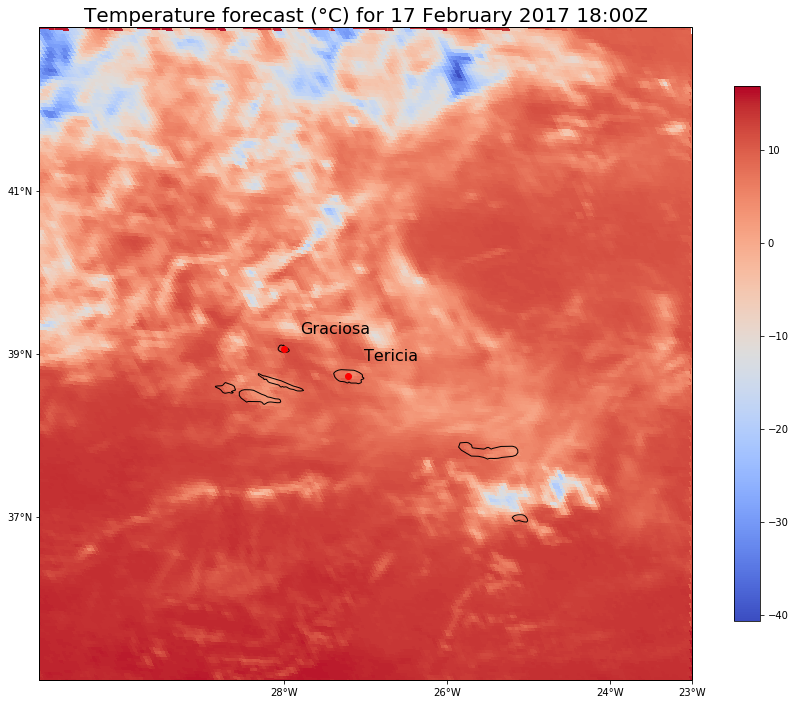

In [69]:


# Create a new figure
fig = plt.figure(figsize=(15, 12))

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks([-23, -24, -26, -28 ], crs=ccrs.PlateCarree())
ax.set_yticks([37,39,41], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_extent([-23., -31., 35, 43])

# Add state boundaries to plot
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')
_ = ax.add_feature(coast, edgecolor='black')

#ax.add_feature(cfeature.NaturalEarthFeature, edgecolor='black', linewidth=2)

# Contour temperature at each lat/long
cf = ax.pcolormesh(lon_2d, lat_2d, temp_vals, transform=ccrs.PlateCarree(), zorder=0,
                 cmap='coolwarm')

# Plot a colorbar to show temperature and reduce the size of it
plt.colorbar(cf, ax=ax, fraction=0.032)

# Make a title with the time value
ax.set_title(u'Temperature forecast (\u00b0C) for {0:%d %B %Y %H:%MZ}'.format(time_val),
             fontsize=20)


ax.plot([ter_lon, gra_lon], [ter_lat, gra_lat],
       'ro', transform=ccrs.PlateCarree())

ax.text(ter_lon+.2, ter_lat+.2, 
        'Tericia', transform=ccrs.PlateCarree(), fontsize = 16)

ax.text(gra_lon+.2, gra_lat+.2, 
        'Graciosa', transform=ccrs.PlateCarree(), fontsize = 16)

In [70]:
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p5deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p5deg/Best')
best_gfs.datasets
best_ds = list(best_gfs.datasets.values())[0]
best_ds.access_urls
ncss = NCSS(best_ds.access_urls['NetcdfSubset'])


['Temperature_surface', 'reftime', 'time', 'lat', 'lon', 'Planetary_Boundary_Layer_Height_surface', 'MSLP_Eta_model_reduction_msl']


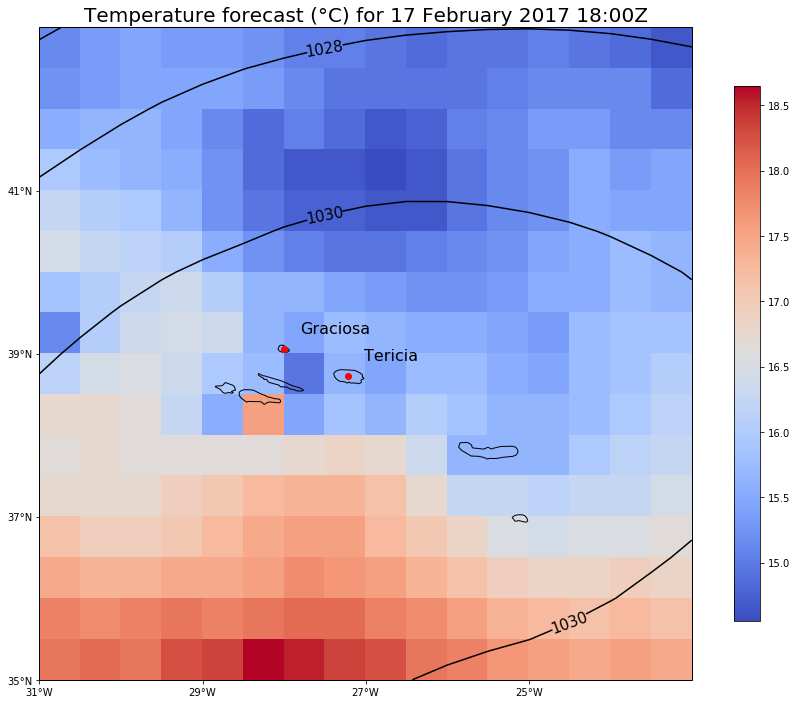

In [71]:
tplot(ncss, [-23., -31., 35, 43], delta=-3, tk=2)

In [72]:
print(datetime.utcnow())

2017-02-17 21:33:33.357932
